# <center> IMDB Sentiment Analysis

The data consists of 50000 comments. There are 25000 negative and 25000 positive comments. Comments are of different lengths and are given in sentences.
Using the imdb dataset, we will train our LSTM model with positive and negative comments about movies. First, we will make comments available for the LSTM model. After training our model, we will examine the accuracy and loss values on the chart.


## Import Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy import stats

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Embedding,LSTM
from tensorflow.python.keras.preprocessing.text import Tokenizer
from keras.optimizers import Adam
from keras.layers import Dropout
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.models import load_model
from sklearn.model_selection import train_test_split
import re
import nltk 
nltk.download("stopwords")
from nltk.corpus import stopwords
nltk.download('punkt')

import warnings
warnings.filterwarnings("ignore")


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
data = pd.read_csv("../input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv")

In [3]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
# we are looking at the size of our data.
data.shape

(50000, 2)

## Exploratory Data Analysis

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


- we see that there is no null value in our data. 

In [6]:
# statistical summary of our data
data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


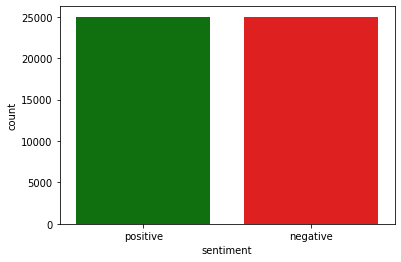

positive    25000
negative    25000
Name: sentiment, dtype: int64


In [7]:
sns.countplot(data["sentiment"], palette = ["green","red"])
plt.show()
print(data.sentiment.value_counts())

<ul>
    <li  style = "color:green" > <p style = "color:black;font-weight:bold" > We see that the number of positive and negative comments is equal. </p> </li>
</ul>

In [8]:
data.sentiment = [ 1 if each == "positive" else 0 for each in data.sentiment]

 We convert our sentiment property to int values. 
 - positive --> 1 
 - negative --> 0 


In [9]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


### Generating word frequencies

Let's first generate a frequency table of all the words present in all the reviews combined.

In [10]:
def gen_freq(text):
    #will store all the words in list
    words_list = []
    
    #Loop over all the words and extract word from list
    for word in text.split():
        words_list.extend(word)
        
    #Generate word frequencies using value counts in word_list
    word_freq = pd.Series(words_list).value_counts()
    
    #print top 100 words
    word_freq[:100]
    
    return word_freq    

In [11]:
freq = gen_freq(data.review.str)
freq

the               568735
a                 306960
and               301919
of                283625
to                261850
                   ...  
heart-swelling         1
butthorn!"             1
follow!"               1
puppets--              1
20g's...               1
Length: 438729, dtype: int64

## Create Word clouds

### Word cloud using word frequencies

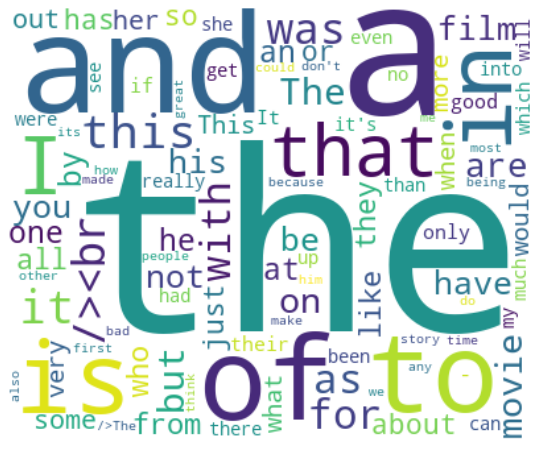

In [12]:
#Import library WordCloud
from wordcloud import WordCloud

#Generate word cloud
wc = WordCloud(width=400, height=330, max_words=100, background_color='white').generate_from_frequencies(freq)

plt.figure(figsize=(14,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

### Word cloud using positive reviews

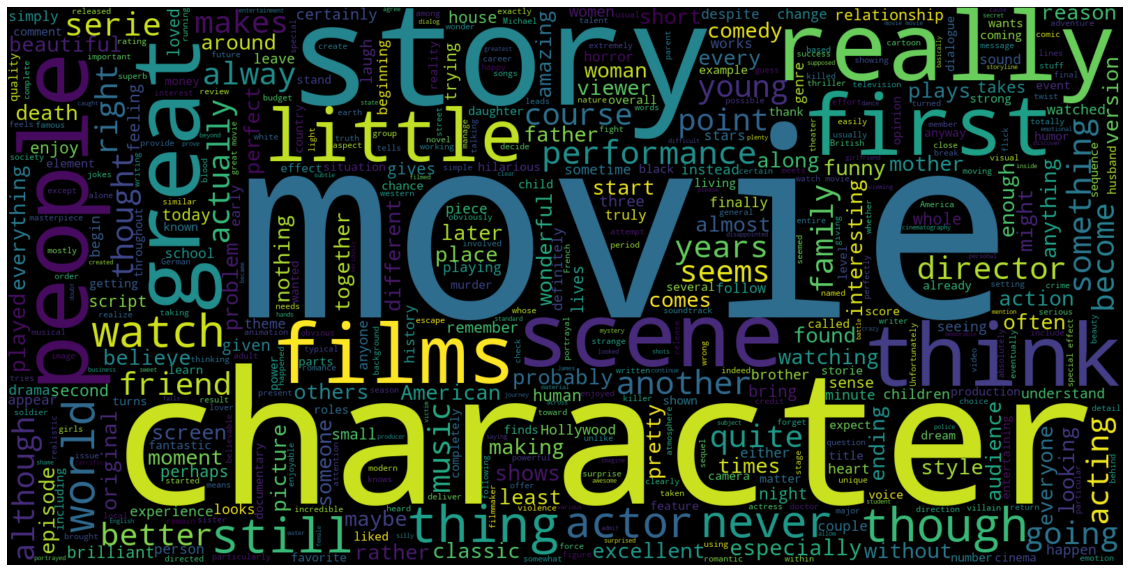

In [13]:
plt.figure(figsize = (20,20))
Wc = WordCloud(max_words = 500 , width = 1600 , height = 800,
               min_word_length=5).generate(" ".join(data[data.sentiment == 1].review))

plt.axis("off")
plt.imshow(Wc , interpolation = 'bilinear')

### Word cloud using negative reviews

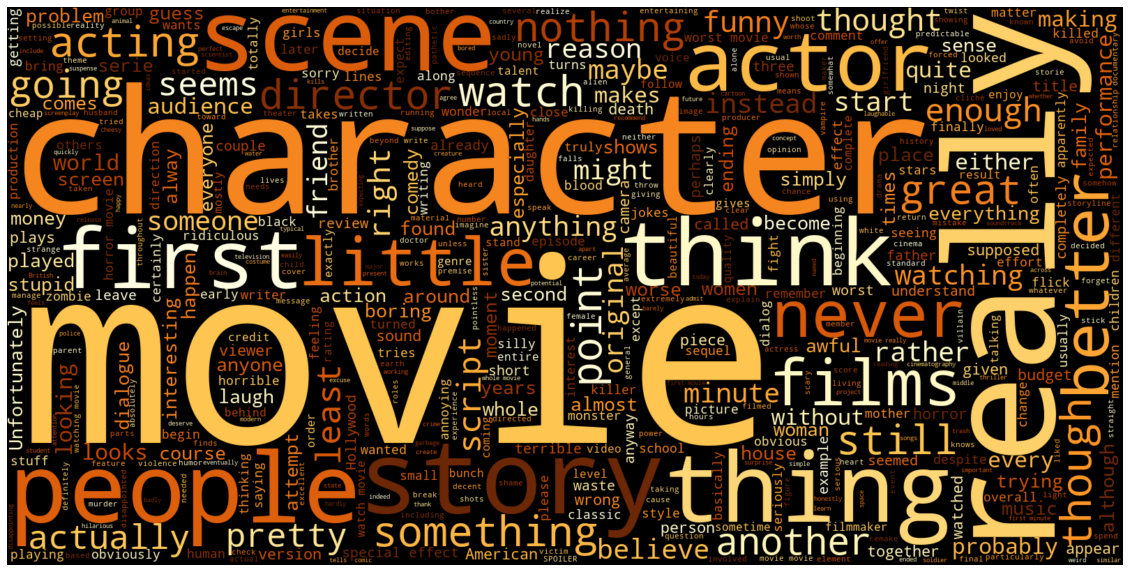

In [14]:
plt.figure(figsize = (20,20))
Wc = WordCloud(max_words = 500 , width = 1600 , height = 800,colormap="YlOrBr",
               min_word_length=5).generate(" ".join(data[data.sentiment == 0].review))

plt.axis("off")
plt.imshow(Wc , interpolation = 'bilinear')

### Removing Stopwords

In [15]:
from nltk.corpus import stopwords
stop_word_list = stopwords.words('english')

In [16]:
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer

In [17]:
#Tokenization of text
tokenizer=ToktokTokenizer()

In [18]:
#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stop_word_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stop_word_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text
#Apply function on review column
data['review']= data['review'].apply(remove_stopwords)

## Text Cleaning

- process of clearing punctuation marks in data
- cleaning unnecessary marks in data. </p> </li>
- capitalization to lowercase. </p> </li>
- cleaning extra spaces. </p> </li>
- removal of stopwords in sentences. </p> </li>


In [19]:
import re
#clearing punctuation & unnecessary marks
data['review'] = data['review'].apply(lambda x: re.sub('[,\.!?:()"]', '', x))
data['review'] = data['review'].apply(lambda x: re.sub('[^a-zA-Z"]', ' ', x))

#capitalization to lowercase
data['review'] = data['review'].apply(lambda x: x.lower())

#cleaning extra spaces
data['review'] = data['review'].apply(lambda x: x.strip())


### Removing html strips and noise text


In [20]:
from bs4 import BeautifulSoup

In [21]:
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text

#Apply function on review column
data['review']=data['review'].apply(denoise_text)

In [22]:
data_copy = data.copy()

## Generating Word clouds after text cleaning :

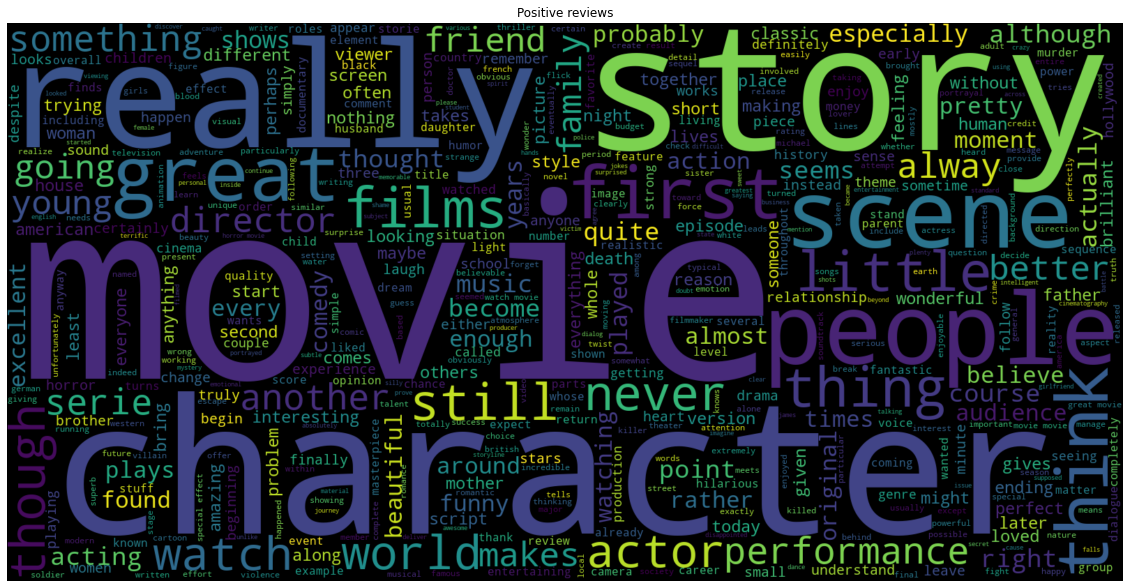

In [23]:
# POSITIVE REVIEWS
plt.figure(figsize = (20,20))
Wc = WordCloud(max_words = 500 , width = 1600 , height = 800,
               min_word_length=5).generate(" ".join(data[data.sentiment == 1].review))

plt.axis("off")
plt.title('Positive reviews')
plt.imshow(Wc , interpolation = 'bilinear')

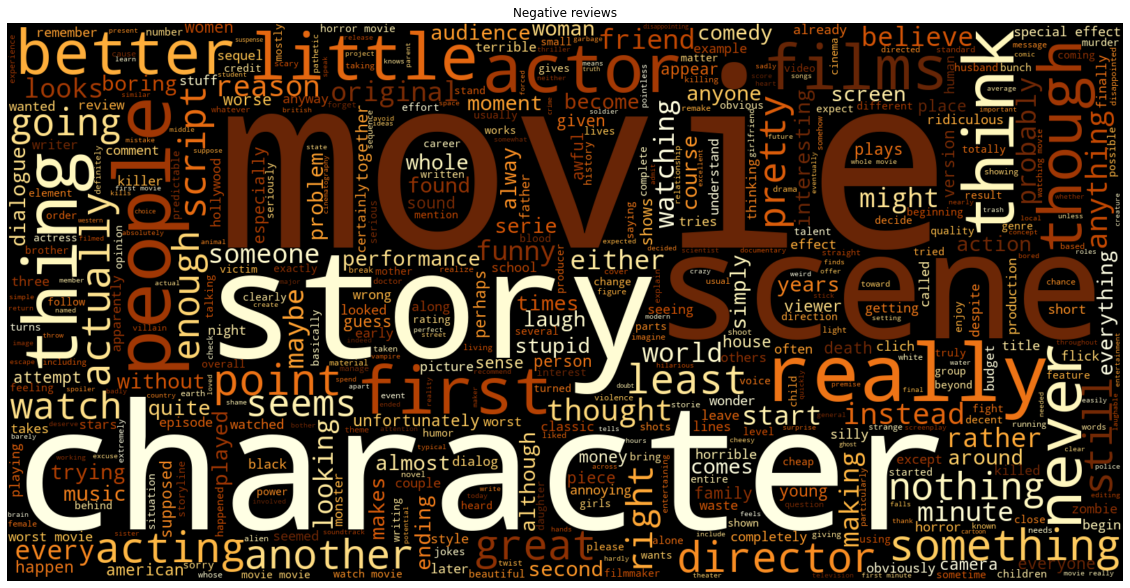

In [24]:
# Negative Reviews
plt.figure(figsize = (20,20))
Wc = WordCloud(max_words = 500 , width = 1600 , height = 800,colormap="YlOrBr",
               min_word_length=5).generate(" ".join(data[data.sentiment == 0].review))

plt.axis("off")
plt.title('Negative reviews')
plt.imshow(Wc , interpolation = 'bilinear')

## Train - Test Split 

In [25]:
sentiment = data['sentiment'].values
sentiment

array([1, 1, 1, ..., 0, 0, 0])

In [26]:
data = data['review']


In [27]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data,sentiment,test_size = 0.2, random_state = 42)

### Creating a Dictionary 
We create a dictionary of 15000 most used words in English for later use. 

In [28]:
from tensorflow.python.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words = 15000)
tokenizer.fit_on_texts(data)
#tokenizer.word_index

#### Bring the comments to the same size
comments of different lengths cannot train the model. That's why we need to make the sentences the same size. 

In [29]:
x_train_tokens = tokenizer.texts_to_sequences(x_train)
x_test_tokens = tokenizer.texts_to_sequences(x_test)

- We can replace the words in our sentences with whichever index they are included in the dictionary we have created above. 

In [30]:
#Then we take the word count of each of our sentences in our data and create a list.
num_tokens = [len(tokens) for tokens in x_train_tokens + x_test_tokens]
num_tokens = np.array(num_tokens)

In [31]:
#Here, when setting the number of tokens, a number is determined by taking into account the variability around the average.
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
max_tokens

292

 max_tokens : This value will allow us to reduce the distribution of sentences in our data and the sentences with opposite lengths, if any, to the average. 

In [32]:
#It is checked what percentage of the data this determined number covers.
np.sum(num_tokens < max_tokens) / len(num_tokens)

0.9454

In [33]:
#data is adjusted according to the number of tokens specified
x_train_pad = pad_sequences(x_train_tokens, maxlen=max_tokens)
x_test_pad = pad_sequences(x_test_tokens, maxlen=max_tokens)

In [34]:
x_train_pad.shape

(40000, 292)

In [35]:
idx = tokenizer.word_index
inverse_map = dict(zip(idx.values(), idx.keys()))

def return_to_sentence(tokens):
    words = [inverse_map[token] for token in tokens if token!=0]
    text = ' '.join(words)
    return text

- We write a function to revert the sentences that we have made int.


In [36]:
#normal comment
print(return_to_sentence(x_train_pad[9]))

thesis behind rise evil seems br br hitler bad man bad man hated jews case miss going fact every scene film br br there effort whatsoever try explain mood time hitler may adopted views strategy did needless say unlike generally excellent nazis warning history film neglected point fact nearly leaders munich communist rising jewish may views subject linking jews absolutely crucial aspect understanding much nazi era br br but much understanding done film makers going go got stuff knew anyway certainly get fascinating fact hitler briefly socialist communist immediately ww would course far complex film handle might even detract relentless bad away incessantly br br we know bad man however also know figure public speaker private situations could polite even sympathetic course views like anti alcohol anti smoking many guardian readers could agree with also famously fond animals hence wholly invented dog scene absurd br br he also accounts seen brave soldier ww whilst saw iron cross never get 

In [37]:
#token equivalent of comment
print(x_train_pad[9])

[13039   403  2074   352    88     1     1  2064    15    46    15    46
  1695  4385   303   586    73    96    76    49     3     1     1   271
   671  1516   244  1146  1136     7  2064   101  5224  2694 10670  1296
  3034    51   923  1187   210  3462  1635   369     3  6946   119    96
   692  6040 12722  4158  4186  2302   101  2694   685 14522  4385   306
  4159  1183  1656    14  2418   883     1     1   555    14  1656   120
     3  1115    73    54    93   406   569   441   310    16  1324    96
  2064  3101 11031  4158  1111  4883     9   158   123  1190     3  2718
   130     8  6436  6547    15   138 14934     1     1  2197    43    15
    46    95    19    43   729   937  9834  1856  1031    25  9357     8
  2091   158  2694     5   975  4630   975  3056    34  7503  6075    25
   913   876    19 14028  4150  1474  2818  5298  5109   675    49  1762
     1     1  2289    19  5945    35  2681  1424  4883  1710   111  3887
  1506    37    16    12  1292  9531   126  3034   

##  LSTM Model 

In [38]:
model = Sequential()

embedding_size = 50

model.add(Embedding(input_dim=15000,output_dim=embedding_size,input_length=max_tokens,name='embedding_layer'))

model.add(LSTM(units=16, return_sequences=True))
model.add(Dropout(0.1))

model.add(LSTM(units=8, return_sequences=True))
model.add(Dropout(0.1))

model.add(LSTM(units=4))
model.add(Dropout(0.1))

model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(lr=1e-3)

model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, 292, 50)           750000    
_________________________________________________________________
lstm (LSTM)                  (None, 292, 16)           4288      
_________________________________________________________________
dropout (Dropout)            (None, 292, 16)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 292, 8)            800       
_________________________________________________________________
dropout_1 (Dropout)          (None, 292, 8)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 4)                 208       
_________________________________________________________________
dropout_2 (Dropout)          (None, 4)                 0

In [40]:
history = model.fit(x_train_pad, y_train, validation_split=0.3, epochs=5, batch_size=1000, shuffle=True, verbose = 1)

Epoch 1/5
28/28 [==============================] - 41s 1s/step - loss: 0.6916 - accuracy: 0.5368 - val_loss: 0.6698 - val_accuracy: 0.6967
Epoch 2/5
28/28 [==============================] - 34s 1s/step - loss: 0.6292 - accuracy: 0.7497 - val_loss: 0.5014 - val_accuracy: 0.8459
Epoch 3/5
28/28 [==============================] - 35s 1s/step - loss: 0.4541 - accuracy: 0.8777 - val_loss: 0.4005 - val_accuracy: 0.8663
Epoch 4/5
28/28 [==============================] - 34s 1s/step - loss: 0.3295 - accuracy: 0.9188 - val_loss: 0.3679 - val_accuracy: 0.8673
Epoch 5/5
28/28 [==============================] - 35s 1s/step - loss: 0.2664 - accuracy: 0.9348 - val_loss: 0.3599 - val_accuracy: 0.8677


### Result 

In [41]:
result = model.evaluate(x_test_pad, y_test)

313/313 [==============================] - 75s 239ms/step - loss: 0.3515 - accuracy: 0.8715


##  Visualization of Accuracy & Loss

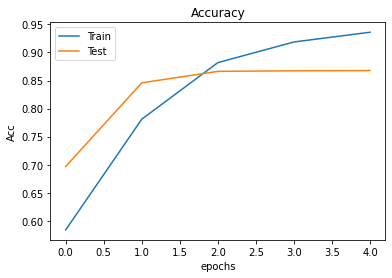

In [42]:
plt.figure()
plt.plot(history.history["accuracy"], label = "Train")
plt.plot(history.history["val_accuracy"], label = "Test")
plt.title("Accuracy")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()

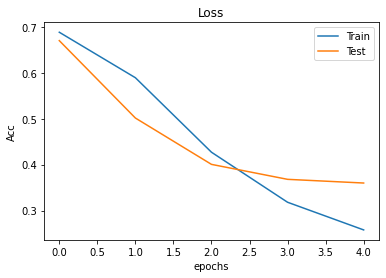

In [43]:
plt.figure()
plt.plot(history.history["loss"], label = "Train")
plt.plot(history.history["val_loss"], label = "Test")
plt.title("Loss")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()

## BERT

In [44]:
train, test= train_test_split(data_copy, test_size=0.2, random_state=42)
Xtrain, ytrain = train['review'], train['sentiment']
Xtest, ytest = test['review'], test['sentiment']
#splitting the train set into train and validation
Xtrain,Xval,ytrain,yval=train_test_split(Xtrain,ytrain,test_size=0.2,random_state=10)

In [45]:
#set up the tokenizer
MAX_VOCAB_SIZE = 10000
tk = Tokenizer(num_words = MAX_VOCAB_SIZE,oov_token="<oov>")
tk.fit_on_texts(Xtrain)
word_index = tk.word_index
#print(word_index)
V = len(word_index)
print("Vocabulary of the dataset is : ",V)

Vocabulary of the dataset is :  87252


In [46]:
##create sequences of reviews
seq_train = tk.texts_to_sequences(Xtrain)
seq_test =  tk.texts_to_sequences(Xtest)

In [47]:
#choice of maximum length of sequences
seq_len_list = [len(i) for i in seq_train + seq_test]

#if we take the direct maximum then
max_len=max(seq_len_list)
print('Maximum length of sequence in the list: {}'.format(max_len))

Maximum length of sequence in the list: 1463


In [48]:
# when setting the maximum length of sequence, variability around the average is used.
max_seq_len = np.mean(seq_len_list) + 2 * np.std(seq_len_list)
max_seq_len = int(max_seq_len)
print('Maximum length of the sequence when considering data only two standard deviations from average: {}'.format(max_seq_len))

Maximum length of the sequence when considering data only two standard deviations from average: 315


In [49]:
import transformers
#Perform tokenization
# automatically download the vocab used during pretraining or fine-tuning a given model,use from_pretrained() method
tokenizer = transformers.AutoTokenizer.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/442 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

In [50]:
#pass our texts to the tokenizer. 
Xtrain_enc = tokenizer(Xtrain.tolist(), max_length=max_seq_len, 
                         truncation=True, padding='max_length', 
                         add_special_tokens=True, return_tensors='np') #return numpy object
Xval_enc = tokenizer(Xval.tolist(), max_length=max_seq_len, 
                         truncation=True, padding='max_length', 
                         add_special_tokens=True, return_tensors='np') #return numpy object
Xtest_enc = tokenizer(Xtest.tolist(), max_length=max_seq_len, 
                         truncation=True, padding='max_length', 
                         add_special_tokens=True, return_tensors='np') #return numpy object

In [51]:
import tensorflow as tf
#preparing our datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(Xtrain_enc),
    ytrain
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(Xval_enc),
    yval
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(Xtest_enc),
    ytest
))

In [52]:
# creating BERT Model
from tensorflow.keras.layers import Dense,Input, Embedding,LSTM,Dropout,Conv1D
from tensorflow.keras.models import Model
def bert_model(train_dataset,val_dataset,transformer,max_len,epochs):
    print("----Building the model----")
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    attention_mask = Input(shape=(max_len,),dtype=tf.int32,name = 'attention_mask') #attention mask
    sequence_output = transformer(input_ids,attention_mask)[0]
    cls_token = sequence_output[:, 0, :]
    x = Dense(512, activation='relu')(cls_token)
    x = Dropout(0.1)(x)
    y = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=[input_ids,attention_mask], outputs=y)
    model.summary()
    model.compile(Adam(lr=2e-5), loss='binary_crossentropy', metrics=['accuracy'])
    r = model.fit(train_dataset.batch(32),batch_size = 32,
                  validation_data = val_dataset.batch(32),epochs = epochs)
                  #callbacks = callbacks
    print("Train score:", model.evaluate(train_dataset.batch(32)))
    print("Validation score:", model.evaluate(val_dataset.batch(32)))
    n_epochs = len(r.history['loss'])
    
    return r,model,n_epochs 

In [53]:
transformer = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/363M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_layer_norm', 'vocab_projector', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [54]:
epochs = 2
max_len = max_seq_len
r,model,n_epochs = bert_model(train_dataset,val_dataset,transformer,max_len,epochs)

----Building the model----
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 315)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 315)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model (TFDistilB TFBaseModelOutput(la 66362880    input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 768)          0           tf

## Linear SVC

In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

In [56]:
text_clf = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', LinearSVC()),])

In [57]:
text_clf.fit(x_train, y_train)


Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', LinearSVC())])

In [62]:
from sklearn.metrics import accuracy_score
predictions = text_clf.predict(x_train)
accuracy_train = accuracy_score(y_train, predictions)
print('Accuracy Score for train :',accuracy_train)

Accuracy Score for train : 0.988425


In [64]:
predictions = text_clf.predict(x_test)
accuracy_test = accuracy_score(y_test, predictions)
print('Accuracy Score for test :',accuracy_test)

Accuracy Score for test : 0.8952


## As we can compare, BERT Model gives best performance with 90% test accuracy score.